Class: DSC630 Data Preparation <br>
Name: Eros Perez<br>
Week: 12<br>
Last Update: 2/25/25

### Initial Model

Accuracy on the test set:  0.7756147540983607
              precision    recall  f1-score   support

    Negative       0.84      0.89      0.86      1853
     Neutral       0.59      0.55      0.57       602
    Positive       0.74      0.62      0.67       473

    accuracy                           0.78      2928
   macro avg       0.72      0.69      0.70      2928
weighted avg       0.77      0.78      0.77      2928



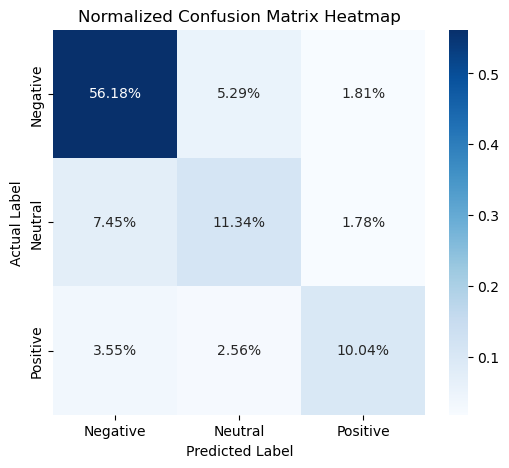

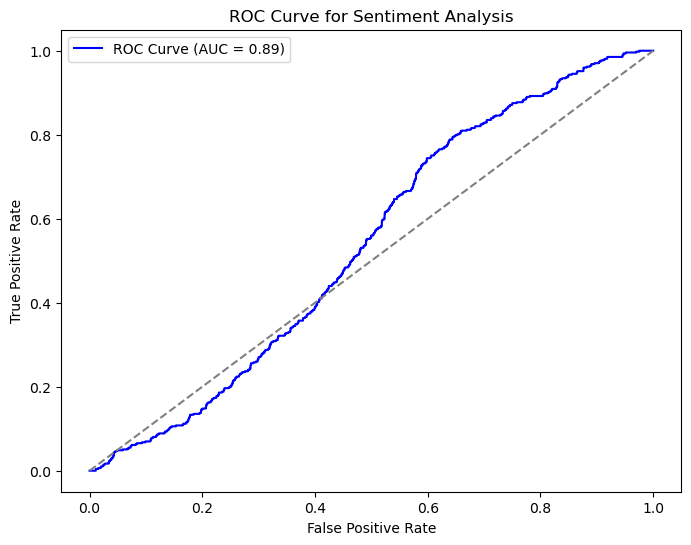

AUC Score: 0.89


In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import accuracy_score, confusion_matrix

### Step 1 ###

#Bring in data
df = pd.read_csv('Tweets.csv')

#Create a column to turn airline sentiment to number values
df['sentiment_numeric'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

#Decrease df size to only include features of interest
df = df[['text','retweet_count','sentiment_numeric','airline_sentiment_confidence']]
df.head()

#Tokenize each word in the text colum
word_tokens = [word_tokenize(text) for text in df.text]

#Create a feature with length of tokens
len_tokens = []

for i in range(len(word_tokens)):
    len_tokens.append(len(word_tokens[i]))

df['n_words'] = len_tokens


# Convert frozenset to list so that my stop words do not result in an error
stop_words_list = list(ENGLISH_STOP_WORDS) # + ["medical", "weight"] Only add this to add additional stop words


# ### STEP 2 ####

# Build vectorizer
vect = TfidfVectorizer(stop_words=stop_words_list,
                       lowercase=True,
                       ngram_range=(1, 3), 
                       max_features=400, 
                       token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(df.text)
#Transform vect
X_vect = vect.transform(df.text)

#Turn transform vect back to dataframe
text_transformed = pd.DataFrame(X_vect.toarray(), columns = vect.get_feature_names_out())

#Join target variable and features from original df back to transformed one
final_df = pd.concat([text_transformed, df[['retweet_count', 'n_words', 'sentiment_numeric','airline_sentiment_confidence']]], axis=1)

### STEP 3 ###
#Build a Classifier

y = final_df.sentiment_numeric
X = final_df.drop('sentiment_numeric', axis = 1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)

#Scale my data as the additional features vary drastically from the binary variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# Train a logistic regression
model = LogisticRegression(penalty = 'l2', C=.10).fit(X_train_scaled, y_train)

#Predict labels
y_predicted = model.predict(X_test_scaled)

# Print accuracy score and confusion matrix on test set
print('Accuracy on the test set: ', accuracy_score(y_test, y_predicted))
# print(confusion_matrix(y_test, y_predicted)/len(y_test))

conf_matrix = confusion_matrix(y_test, y_predicted) / len(y_test)

# Define class labels (adjust based on your dataset)
labels = ["Negative", "Neutral", "Positive"]

# Create heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt=".2%", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Titles and Labels
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Normalized Confusion Matrix Heatmap")
plt.show

# Generate classification report
report = classification_report(y_test, y_predicted, target_names=["Negative", "Neutral", "Positive"])

# Print results
print(report)

#ROC curve and AUC
# Get predicted probabilities
y_probs = model.predict_proba(X_test_scaled)  # Returns probability for each class
y_probs_positive = y_probs[:, 1]  # Extract probabilities for the Positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive, pos_label=2)  # Adjust pos_label if necessary

# Compute AUC
auc_score = roc_auc_score(y_test, model.predict_proba(X_test_scaled), multi_class="ovr")  

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Sentiment Analysis")
plt.legend()
plt.show()

# Print AUC score
print(f"AUC Score: {auc_score:.2f}")

### Sentiment Analysis Across 7 models using TF_IDF

In [1]:
#Import Modules

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

In [3]:
#Bring in data
df = pd.read_csv('Tweets.csv')

#### 1) Exploratory Data Analysis

Dataset Overview:

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created              

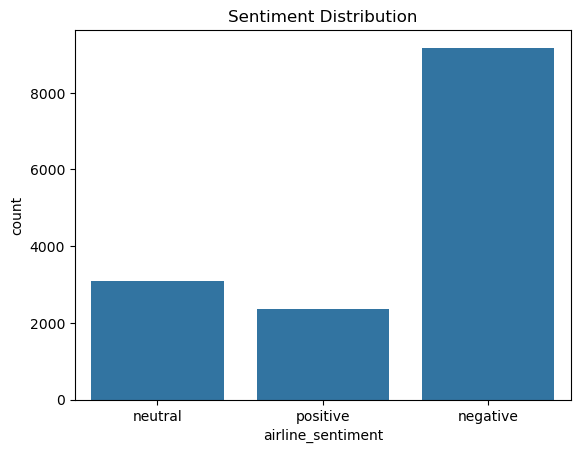

In [5]:
#Overview of data
print('Dataset Overview:')
df.head()

#Summary of Data
print('\nData Summary:')
df.info()

#Distribution of classes
print('\nClass Distribution')
print(df['airline_sentiment'].value_counts())

#Distribution of classses using percentages
print('\nPercentage Class Distribution')
print(df['airline_sentiment'].value_counts() / len(df) *100)

#Visualize distribution of classes
sns.countplot(x=df['airline_sentiment'])
plt.title('Sentiment Distribution')
plt.show()

### 2) Data Cleaning

In [7]:
#Let's create a function that can clean the data

def clean_text(text):
    text = text.lower() #This is so we can make text lowercase
    text = re.sub(r'http\S+', '', text) #This is to remove URL's
    text = re.sub(r'[^a-zA-Z ]', '', text) # This is to remove special characters such as the @ symbol

    return text

df['clean_text'] = df['text'].apply(clean_text)

df[['text','clean_text']].head()

,text,clean_text
0,@VirginAmerica What @dhepburn said.,virginamerica what dhepburn said
1,@VirginAmerica plus you've added commercials t...,virginamerica plus youve added commercials to ...
2,@VirginAmerica I didn't today... Must mean I n...,virginamerica i didnt today must mean i need t...
3,@VirginAmerica it's really aggressive to blast...,virginamerica its really aggressive to blast o...
4,@VirginAmerica and it's a really big bad thing...,virginamerica and its a really big bad thing a...


### 3) Prepare Data For Modeling

In [9]:
#The Label Encoder will turn the categorcal text values in airline_sentiment to numerical values
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['airline_sentiment'])

#Now Let's split the data for testing
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sentiment_label'], test_size = 0.2, random_state = 42)

#Now let's perform feature extraction using TF-IDF now that the data is split. This avoids data leakage
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test) 

### 4) Train Models

In [11]:
# Model 1: Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)
log_reg_preds = log_reg.predict(X_test_tfidf)
log_reg_proba = log_reg.predict_proba(X_test_tfidf)

# Model 2: TextBlob
def textblob_sentiment(text):
    return 1 if TextBlob(text).sentiment.polarity > 0 else 0

df['textblob_pred'] = df['clean_text'].apply(textblob_sentiment)

# Model 3: Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_preds = nb.predict(X_test_tfidf)
nb_proba = nb.predict_proba(X_test_tfidf)

# Model 4: Support Vector Machine (SVM)
svm = SVC(probability=True)
svm.fit(X_train_tfidf, y_train)
svm_preds = svm.predict(X_test_tfidf)
svm_proba = svm.predict_proba(X_test_tfidf)

# Model 5: Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
rf_preds = rf.predict(X_test_tfidf)
rf_proba = rf.predict_proba(X_test_tfidf)

# Model 6: Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_tfidf, y_train)
dt_preds = dt.predict(X_test_tfidf)
dt_proba = dt.predict_proba(X_test_tfidf)

# Model 7: Ensemble Model
ensemble_model = VotingClassifier(estimators=[('log_reg', log_reg), ('nb', nb), ('svm', svm), ('rf', rf), ('dt', dt)], voting='soft')
ensemble_model.fit(X_train_tfidf, y_train)
ensemble_preds = ensemble_model.predict(X_test_tfidf)
ensemble_proba = ensemble_model.predict_proba(X_test_tfidf)

### 5) Evaluate Models


Performance Metrics for Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1889
           1       0.66      0.53      0.59       580
           2       0.81      0.61      0.69       459

    accuracy                           0.80      2928
   macro avg       0.77      0.69      0.72      2928
weighted avg       0.80      0.80      0.79      2928



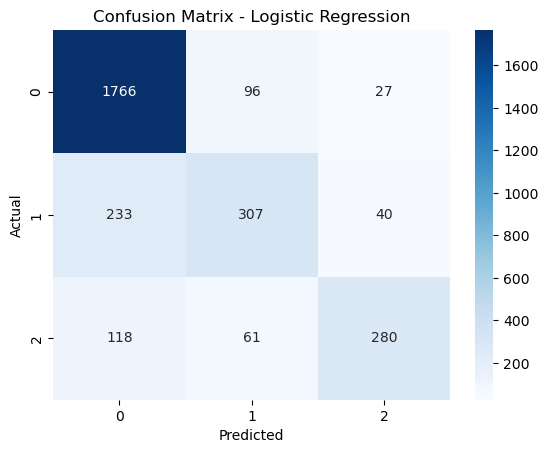

ROC AUC Score for Logistic Regression: 0.91

Performance Metrics for TextBlob:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1889
           1       0.18      0.33      0.23       580
           2       0.00      0.00      0.00       459

    accuracy                           0.52      2928
   macro avg       0.30      0.35      0.32      2928
weighted avg       0.50      0.52      0.51      2928



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


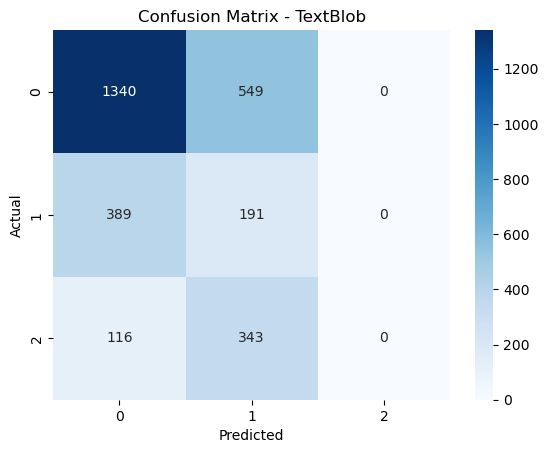


Performance Metrics for Naive Bayes:
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      1889
           1       0.75      0.12      0.21       580
           2       0.94      0.16      0.27       459

    accuracy                           0.69      2928
   macro avg       0.79      0.43      0.43      2928
weighted avg       0.74      0.69      0.61      2928



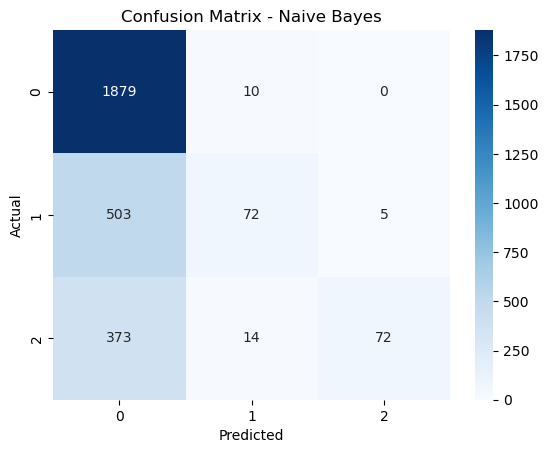

ROC AUC Score for Naive Bayes: 0.88

Performance Metrics for SVM:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1889
           1       0.69      0.48      0.57       580
           2       0.82      0.60      0.69       459

    accuracy                           0.80      2928
   macro avg       0.78      0.68      0.71      2928
weighted avg       0.79      0.80      0.79      2928



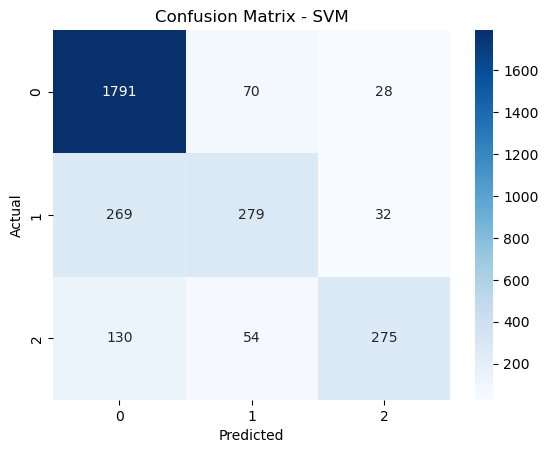

ROC AUC Score for SVM: 0.91

Performance Metrics for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1889
           1       0.69      0.39      0.50       580
           2       0.84      0.44      0.58       459

    accuracy                           0.77      2928
   macro avg       0.77      0.60      0.65      2928
weighted avg       0.77      0.77      0.75      2928



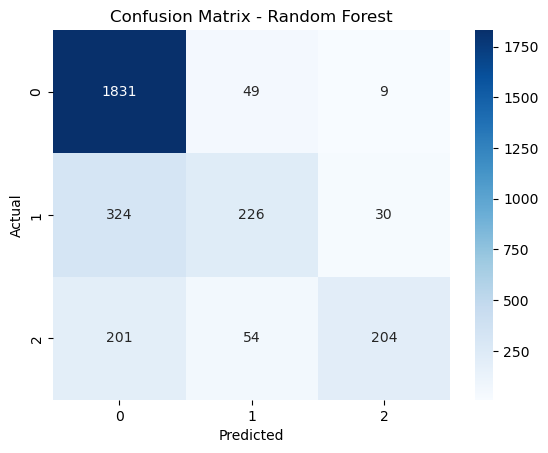

ROC AUC Score for Random Forest: 0.88

Performance Metrics for Decision Tree:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1889
           1       0.41      0.45      0.43       580
           2       0.52      0.53      0.52       459

    accuracy                           0.67      2928
   macro avg       0.58      0.59      0.58      2928
weighted avg       0.68      0.67      0.68      2928



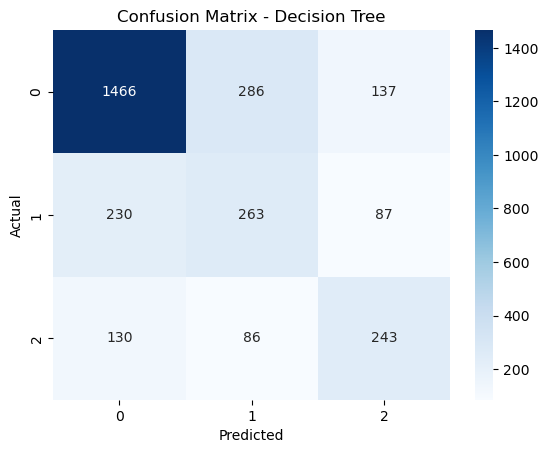

ROC AUC Score for Decision Tree: 0.69

Performance Metrics for Ensemble:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1889
           1       0.69      0.44      0.54       580
           2       0.78      0.56      0.65       459

    accuracy                           0.79      2928
   macro avg       0.76      0.65      0.69      2928
weighted avg       0.78      0.79      0.77      2928



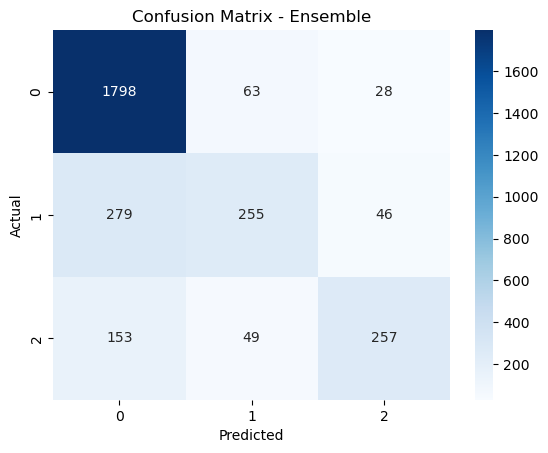

ROC AUC Score for Ensemble: 0.90


In [13]:
#Create function to evaluate performance of models
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\nPerformance Metrics for {model_name}:")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
        print(f"ROC AUC Score for {model_name}: {roc_auc:.2f}")
    
    return accuracy_score(y_true, y_pred)

# Evaluate all models
accuracy_scores = {}
accuracy_scores['Logistic Regression'] = evaluate_model(y_test, log_reg_preds, log_reg_proba, 'Logistic Regression')
accuracy_scores['TextBlob'] = evaluate_model(y_test, df['textblob_pred'].iloc[X_test.index], None, 'TextBlob')
accuracy_scores['Naive Bayes'] = evaluate_model(y_test, nb_preds, nb_proba, 'Naive Bayes')
accuracy_scores['SVM'] = evaluate_model(y_test, svm_preds, svm_proba, 'SVM')
accuracy_scores['Random Forest'] = evaluate_model(y_test, rf_preds, rf_proba, 'Random Forest')
accuracy_scores['Decision Tree'] = evaluate_model(y_test, dt_preds, dt_proba, 'Decision Tree')
accuracy_scores['Ensemble'] = evaluate_model(y_test, ensemble_preds, ensemble_proba, 'Ensemble')

### 6) Select Best Model

In [37]:
best_model = max(accuracy_scores, key=accuracy_scores.get)
print(f"The best performing model based on accuracy is: {best_model}")

results = pd.DataFrame(list(accuracy_scores.items()), columns=['models', 'results'])
results.sort_values(by='results', ascending = False)

The best performing model based on accuracy is: Logistic Regression


,models,results
0,Logistic Regression,0.803620
3,SVM,0.800888
6,Ensemble,0.788934
4,Random Forest,0.772199
2,Naive Bayes,0.690915
5,Decision Tree,0.673497
1,TextBlob,0.522883
